In [ ]:
!pip install -U sentence-transformers

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D,GlobalMaxPooling1D,BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = '/content/drive/My Drive/Datasets/ToxicityClassification'

## Load Dataset

The original dataset from kaggle contains 159571 rows. However, as observed in the graph below, the dataset is highly unbalanced towards the null class, while frequency of the severe_toxic, threat, and identity_hate class is extremely low.

Amongst the labelled classes, the toxic label seems to have a good proportion, mainly because it is a general class and most of the data belonging to either of the other five classes also falls in the toxic class aswell.

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


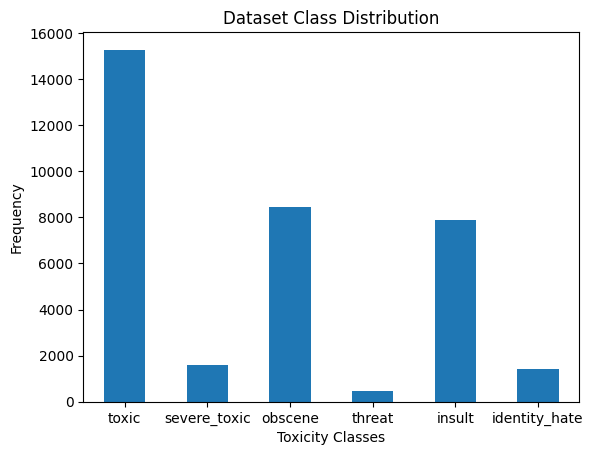

In [ ]:
df = pd.read_csv(drive_path+"/train.csv")

x_train = list(df['comment_text'].reset_index(drop=True))

y_data = df.iloc[:, -6:].reset_index(drop=True)

column_labels = list(y_data.columns)
print(column_labels)

# display(y_data)

y_columns = list(df.columns)

# draw bar graph to visualise the data distribution
freqs = y_data.sum()

freqs.plot(kind='bar', rot=0)
plt.title('Dataset Class Distribution')
plt.xlabel('Toxicity Classes')
plt.ylabel('Frequency')
plt.show()


## Obtain embeddings from SentenceTransformer

The SentenceTransformer library is specifically designed for creating sentence embeddings. It has several pre-trained models that have been trained on a diverse dataset which is highly beneficial, since it allows for the creation of generalizable embeddings.

all-MiniLM-L6-v2 maps sentences & paragraphs to a 384 dimensional dense vector space and it is designed to be used for tasks like clustering or semantic search.

In [ ]:
# Choosing the sentence embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
# x_train_embeddings = embedding_model.encode(x_train)

## Undersample data with 0 Class for training

Since 90% of the dataset contains the 0 class, training the model on the entire dataset will not be a fruitful exercise. Instead, we will undersample the non-toxic class to match the toxic class in our dataset.

Ideally, we would want every class in the dataset to have equal representation, however given the extremely low presence of the 3 minority classes, undersampling every class to the level of 500 datapoints would leave us with very less data, therefore, it won't be possible to train a model that could be generalized on real-world data.

Therefore, we strike a balance between the non-toxic and toxic class. This allows us to build a model that is able to generalize when dealing with toxic/non-toxic class. It also detects other specialized classes, however, due to the lack of training data for those classes, the model probably won't be able to generalize as well on those classes.



## Reshape x_train, add additional dimension for LSTM

The LSTM architecture expects the input data to be in the form of a 3d tensor.

In [ ]:

y_data = y_undersampled
x_train_reshaped = np.reshape(x_undersampled, (x_undersampled.shape[0], 1, x_undersampled.shape[1]))
print("x_train_reshaped:",x_train_reshaped.shape)
print("y_data.shape:",y_data.shape)


x_train_reshaped: (26450, 1, 384)
y_data.shape: (26450, 6)


## Split Data into 3 sets

Splitting the data in an 80/10/10 ratio.

The Validation data will be used to keep a check on the models performance during trained.

The train data is used later for evaluation once the training process has completed.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(x_train_reshaped, y_data, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shapes:")
print("X Train:", X_train.shape)
print("y Train:", y_train.shape)
print("X Test:", X_test.shape)
print("y Test:", y_test.shape)
print("X Val:", X_val.shape)
print("y Val:", y_val.shape)



Shapes:
X Train: (21160, 1, 384)
y Train: (21160, 6)
X Test: (2645, 1, 384)
y Test: (2645, 6)
X Val: (2645, 1, 384)
y Val: (2645, 6)


## Analyze the distribution of classes after undersampling

Data belonging to 0 class is now almost 38% of the entire dataset. Data belonging to the toxic class has a slightly higher frequency, however, the instances of the other labels still remain significantly low.

8160
Total Train Data Points:  21160
Percentage of 0 class in train data: 38.56%
data left  =  13000
[12242, 1280, 6776, 382, 6343, 1142]


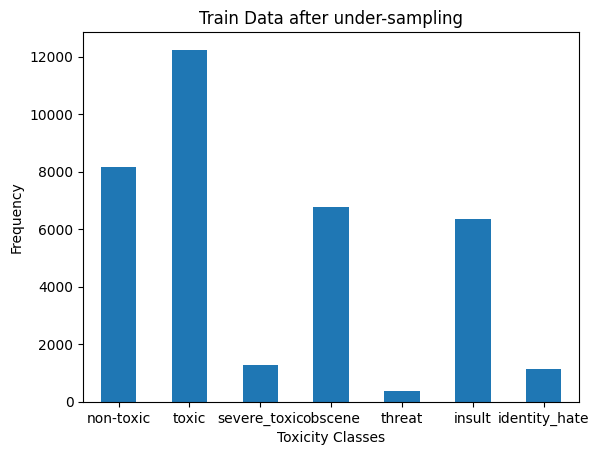

In [ ]:
counterzero = 0
counter_total = [0 ,0 ,0 ,0 ,0 ,0]

y_train_df = pd.DataFrame(y_train, columns=column_labels)

# print(type(y_train_df))

for index, row in y_train_df.iterrows():
    if row[0] == 0 and row[1] == 0 and row[2] == 0 and row[3] == 0 and row[4] == 0 and row[5] == 0:
        counterzero +=1
    if row[0] == 1:
        counter_total[0] +=1
    if row[1] == 1:
        counter_total[1] +=1
    if row[2] == 1:
        counter_total[2] +=1
    if row[3] == 1:
        counter_total[3] +=1
    if row[4] == 1:
        counter_total[4] +=1
    if row[5] == 1:
        counter_total[5] +=1


print(counterzero)
print("Total Train Data Points: ",X_train.shape[0])
print(f"Percentage of 0 class in train data: {100*float(counterzero)/X_train.shape[0]:.2f}%")
print("data left  = " ,  X_train.shape[0]- counterzero)
print(counter_total)

train_freqs = y_train_df.sum()
zero_df = pd.Series([counterzero], index=['non-toxic'])
train_freqs = pd.concat([zero_df, train_freqs])

train_freqs.plot(kind='bar', rot=0)
plt.title('Train Data after under-sampling')
plt.xlabel('Toxicity Classes')
plt.ylabel('Frequency')
plt.show()

## Defining the LSTM Model

The model chosen is primarily based on bidirectional LSTM-based neural network. LSTM is being used since it is better at keeping track of important long-term as well as short-term memory. This property of the LSTM is one of the main reasons for choosing it since the dataset contains sentences of varying length and complexity. The model was chosen to be bidirectional since it is generally more effective in capturing the contextual information in textual data.

Convolutional and pooling layers are then utilized to extract low and high-level features, followed by batch normalization for stability.

Convolution allows us to capture low level-features such as individual words that may have a high value in the classification of the sentece. Pooling allows us to capture high-level features such as the overall structure of the sentence.

The model further includes fully connected layers with dropout for regularization and concludes with a sigmoid activation layer for binary classification across six toxicity categories.

The Adam optimizer is employed with a binary crossentropy loss function, and the model is compiled for training with an adaptive learning rate.

Adam was chosen as the optimizer due to its versatility in producing good results for different tasks. Its use of adaptive learning rate, momentum, and the nature of Stochastic Gradient Descent make it a suitable choice.

In [ ]:
model = Sequential()

# capture sequential data using lstm
model.add(Bidirectional(LSTM(32, input_shape=(1,384), return_sequences=True, name='lstm_layer_1')))
model.add(Bidirectional(LSTM(64, return_sequences=True, name='lstm_layer_2')))
# model.add(Bidirectional(LSTM(64, return_sequences=True, name='lstm_layer_3')))

# extract low-level features locally
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))

# extract generalizable, high level features
model.add(GlobalMaxPooling1D())

# normalizing for stability
model.add(BatchNormalization())


# Add fully connected layers
model.add(Dense(32, activation='relu'))  #feel like
model.add(Dropout(0.4)) # reduces over-fitting
# model.add(Dense(16, activation='relu'))  #feel like
# model.add(Dropout(0.4)) # reduces over-fitting
model.add(Dense(6, activation='sigmoid')) # gets 6 sigmoid outputs


adam_optimizer = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Define Model

In [ ]:
# loading trained model in previous runtime

model.load_weights(drive_path+"/model_weights_new.h5")

## Training the model

The model is trained for 10 epochs. This value has been chosen after experimenting with different, higher and lower values.

As shown in the graph below, the model's loss starts converging after the first epoch however, the models starts to over-fit as the number of epochs increase beyond 10.

Binary cross entropy loss has been chosen as the loss metric since each class is binary. This aligns with the use of the final sigmoid layer in the model which gives an output between 0 and 1.

In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
662/662 [==============================] - 24s 18ms/step - loss: 0.2977 - accuracy: 0.8092 - val_loss: 0.2439 - val_accuracy: 0.9652
Epoch 2/10
662/662 [==============================] - 7s 11ms/step - loss: 0.2446 - accuracy: 0.9288 - val_loss: 0.2191 - val_accuracy: 0.9629
Epoch 3/10
662/662 [==============================] - 11s 16ms/step - loss: 0.2348 - accuracy: 0.9404 - val_loss: 0.2127 - val_accuracy: 0.9652
Epoch 4/10
662/662 [==============================] - 14s 21ms/step - loss: 0.2283 - accuracy: 0.9448 - val_loss: 0.2081 - val_accuracy: 0.9652
Epoch 5/10
662/662 [==============================] - 12s 18ms/step - loss: 0.2253 - accuracy: 0.9541 - val_loss: 0.2076 - val_accuracy: 0.9652
Epoch 6/10
662/662 [==============================] - 13s 20ms/step - loss: 0.2202 - accuracy: 0.9494 - val_loss: 0.2119 - val_accuracy: 0.9652
Epoch 7/10
662/662 [==============================] - 13s 19ms/step - loss: 0.2177 - accuracy: 0.9514 - val_loss: 0.2082 - val_accuracy: 

## Train Error Plot

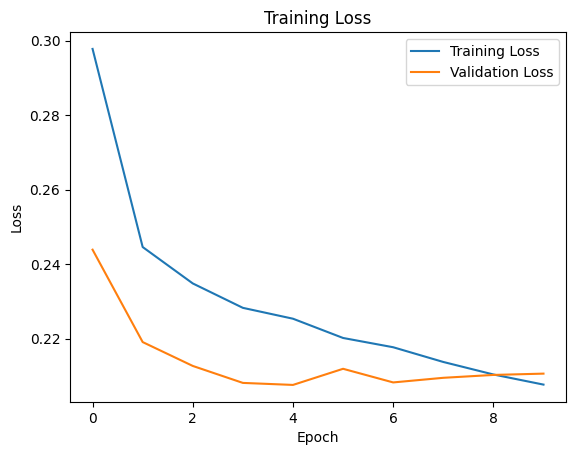

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pickle

# save model weights
model.save_weights('model_weights_new.h5')

# # save embeddings
# with open('embeddings.pkl', 'wb') as file:
#     pickle.dump(x_train_embeddings, file)


## Apply Model on Test Data

Since the model has now been trained, it is now time to evaluate its performance on unseen data. The model is used to get a prediction on the entire test dataset. The prediction for each class from the model will be a sigmoid value, which is between 0 and 1.

As per convention, we will be keeping a fixed class cutoff at 0.5 for each class.

In [ ]:

# get predictions
probs = model.predict(X_test)

predictions = (probs > 0.5).astype(int)





83/83 [==============================] - 3s 9ms/step


## Analyzing Test Data Results

The model is able to achieve an overall accuracy of 90.7% on the dataset. Since most of the testing data contains either the toxic/non-toxic class, we can see with good confidence that the model is able to generalize on the this class.

However, to analyze the minority classes, it is important to consider the individual confusion matrix for each class.

Here are a few key observations:


*   As expected, the precision and recall for the toxic class are around 90% which aligns with the overall test accuracy of the model as well.
*   The obscene and threat classes, being the third and fourth highly represented classes in the dataset have a precision and recall in the range of 70-75%. This indicates that had there been more data, the model could also have generalized over these classes as it did with the toxic class.

*   The remaining three classes, comprising almost 10% of the dataset have not been able to generalize at all on the given model. This is a limitation of the our sequential model, and the only way to improve performance of these classes is to increase the number of training instances for these classes to achieve a class balance. Furthermore, other approaches such as adjusting class weights during training may help improve model performance on minority classes.

*  While the three minority classes have low precision and accuracy scores, we must note that before undersampling the data, the two metrics mentioned above were even lower, and the recall for the classes was close to 0. This shows that the slight reduction in class imbalance following our efforts of undersampling have had a positive effect on these classes as well, and further improving the dataset would be the best way to improve the metrics for these classes.

Given the constraints of the current model and dataset, improved results with fewer training instances may be achieved by exploring advanced models like Large Language Models (LLMs) and Encoder-Decoder networks. In our project, we focus on LLMs, demonstrating notable enhancements in classification results. These sophisticated architectures excel in capturing complex patterns and contextual information, making them valuable for addressing challenges in imbalanced datasets and achieving superior performance across diverse classes.



(2645, 6)
(2645, 6)
Test Accuracy: 0.9040327662255828
F1 Score: 0.9040327662255828


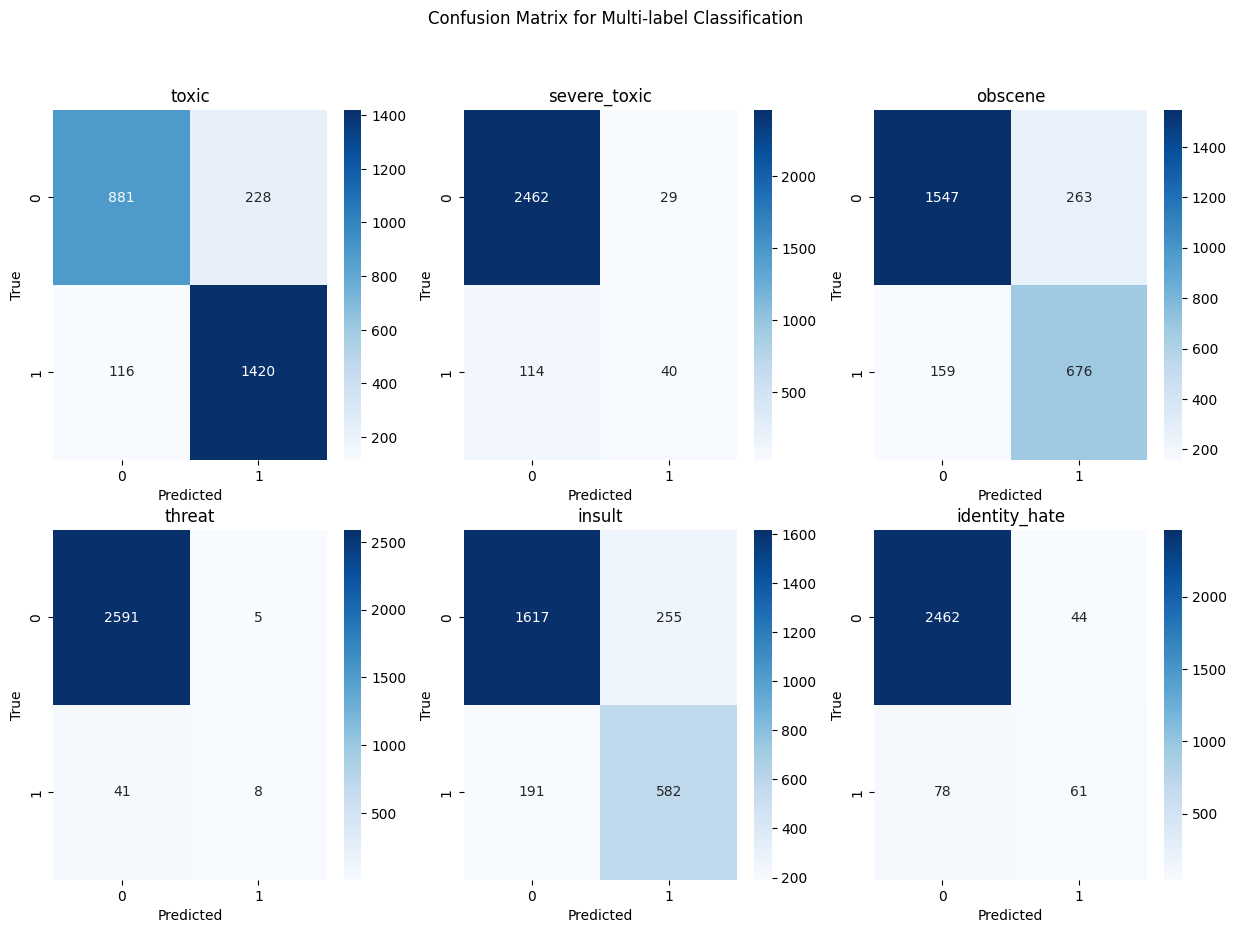

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix,confusion_matrix
import seaborn as sns

y_test_arr = np.array(y_test)
column_labels = list(df.columns[-6:])

print(y_test_arr.shape)
print(predictions.shape)
# Get Test Accuracy, F1 Score, and Confusion Matrix
test_accuracy = accuracy_score(y_test_arr.flatten(), predictions.flatten())
f1 = f1_score(y_test_arr.flatten(), predictions.flatten(), average='micro')
conf_matrix = multilabel_confusion_matrix(y_test_arr, predictions)

print(f'Test Accuracy: {test_accuracy}')
print(f'F1 Score: {f1}')

# plot conf matrix for each label seperately
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{column_labels[i]}')

plt.suptitle('Confusion Matrix for Multi-label Classification')
plt.show()


## Print classification report to analyze precision and recall

In [ ]:
from sklearn.metrics import classification_report, hamming_loss

# classification report
print("Classification Report:")
print(classification_report(y_test_arr, predictions))

# hl = hamming_loss(y_test_arr, predictions)
# print(f"Hamming Loss: {hl:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1536
           1       0.58      0.26      0.36       154
           2       0.72      0.81      0.76       835
           3       0.62      0.16      0.26        49
           4       0.70      0.75      0.72       773
           5       0.58      0.44      0.50       139

   micro avg       0.77      0.80      0.79      3486
   macro avg       0.68      0.56      0.58      3486
weighted avg       0.76      0.80      0.78      3486
 samples avg       0.47      0.49      0.46      3486



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ROC AUC Curves and evaluation for each class



1.   ROC AUC scores show that the model excels in discriminating toxic and obscene comments, with AUC values of 0.859 and 0.832. This alignes with the high precision, recall, and f1-scores in the classification report for these classes.
2.   Challenges arise in accurately identifying severe_toxic and threat comments. This is reflected in lower ROC AUC scores of 0.624 and 0.581, and the corresponding lower precision, recall, and f1-scores shown above.

3. Effective discrimination is observed for insult comments (AUC = 0.808) and moderate performance for identity_hate comments (AUC = 0.711), consistent with classification report metrics for these classes.



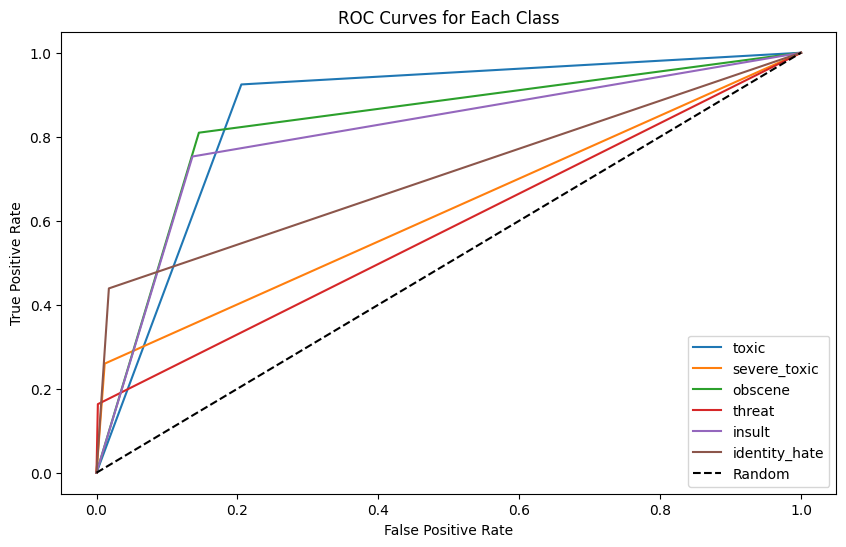



ROC AUC for toxic Class: 0.859
ROC AUC for severe_toxic Class: 0.624
ROC AUC for obscene Class: 0.832
ROC AUC for threat Class: 0.581
ROC AUC for insult Class: 0.808
ROC AUC for identity_hate Class: 0.711

Mean ROC AUC: 0.736


In [ ]:
from sklearn.metrics import roc_curve, auc

roc_auc_list = []

plt.figure(figsize=(10, 6))
for i in range(predictions.shape[1]):
    # get fp and tp for each class and calculate area under the ROC curve
    fp, tp, _ = roc_curve(y_test_arr[:, i], predictions[:, i])
    roc_auc = auc(fp, tp)
    roc_auc_list.append(roc_auc)

    plt.plot(fp, tp, label=f'{y_columns[i+2]}')

# Plot the random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()

print("\n")
for i, each in enumerate(roc_auc_list):
    print(f"ROC AUC for {y_columns[i+2]} Class: {each:.3f}")

mean_roc = np.mean(roc_auc_list)
print(f"\nMean ROC AUC: {mean_roc:.3f}")


